In [2]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns
sns.set()

## Import Dataset

In [3]:
real_data = pd.read_csv('real_ctdata.csv')
syn_data = pd.read_csv('ctgan_synthetic_382.csv')

In [4]:
real_data.columns

Index(['subject_id', 'insurance', 'ethnicity', 'gender', 'expire_flag', 'los',
       'hospital_expire_flag'],
      dtype='object')

In [5]:
real_data = real_data.loc[:, ~real_data.columns.str.contains('^Unnamed')]
syn_data = syn_data.loc[:, ~syn_data.columns.str.contains('^Unnamed')]
#synthetic_data = synthetic_data.drop(columns = ['sample_index'])

In [6]:
real_data.shape, syn_data.shape

((382, 7), (382, 7))

In [7]:
##Separate dataset by data types

# get id columns
real_id = real_data.loc[:, real_data.columns.str.contains('id')]
# get time series columns
real_ts = real_data.loc[:, real_data.columns.str.contains("time|dob|dod")]
# get numerical columns
real_num = real_data._get_numeric_data()
real_bi = real_num.loc[:, real_num.columns.str.contains('has|flag')]
real_num = real_num.loc[:, ~real_num.columns.str.contains('id|time|has|flag')]
# get categorical columns
real_cat = real_data.select_dtypes('object')
real_cat = real_cat.loc[:, ~real_cat.columns.str.contains("time|dob|dod")]
real_cat = pd.concat([real_cat, real_bi], axis=1, sort=False)

##Separate synthetic dataset by data types
# get id columns
syn_id = syn_data.loc[:, syn_data.columns.str.contains('id')]
# get time series columns
syn_ts = syn_data.loc[:, syn_data.columns.str.contains("time|dob|dod")]
# get numerical columns
syn_num = syn_data._get_numeric_data()
syn_bi = syn_num.loc[:, syn_num.columns.str.contains('has|flag')]
syn_num = syn_num.loc[:, ~syn_num.columns.str.contains('id|time|has|flag')]
# get categorical columns
syn_cat = syn_data.select_dtypes('object')
syn_cat = syn_cat.loc[:, ~syn_cat.columns.str.contains("time|dob|dod")]
syn_cat = pd.concat([syn_cat, syn_bi], axis=1, sort=False)

In [8]:
## Normalize numerical columns
from sklearn import preprocessing

def normalize_df(real_num):
    real_num_nor = pd.DataFrame()
    for col in real_num.columns:
        x = real_num[col].values.reshape(-1, 1) #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        result = pd.DataFrame(x_scaled, columns = [col])
        real_num_nor = pd.concat([real_num_nor, result], axis=1, sort=False)
    return real_num_nor

real_num_nor = normalize_df(real_num)
syn_num_nor = normalize_df(syn_num)

## 1) Numerical Data

#### Central Tendency

i.	Mean
ii.	Median
iii.Mode

In [9]:
def central_tendency(real_num_nor,syn_num_nor):
    mean_real = pd.DataFrame(real_num_nor.mean(), columns = ['real_mean'])
    mean_syn = pd.DataFrame(syn_num_nor.mean(), columns = ['syn_mean'])
    mean_df = pd.concat([mean_real, mean_syn], axis=1, sort=False)
    mean_df['diff'] = abs(mean_df['real_mean'] - mean_df['syn_mean'])
    return mean_df

mean_df = central_tendency(real_num_nor,syn_num_nor)

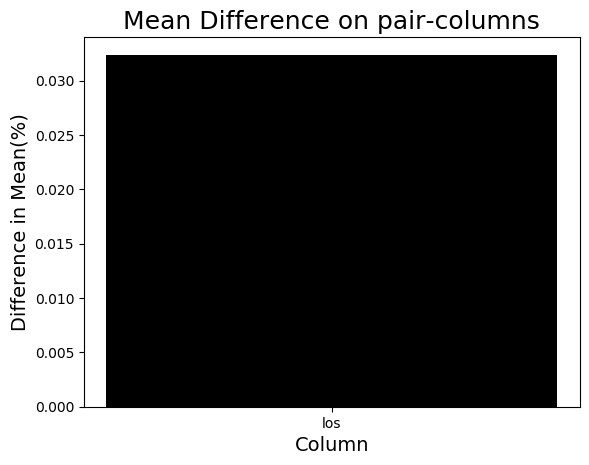

In [10]:
# Plot the result
def plot_result(table):
    plt.style.use('default')
    y_co = table['diff'].values.tolist()
    x_co = table.index.tolist()
    plt.bar(x_co,y_co,  width = 0.5, color = 'black')
    plt.title('Mean Difference on pair-columns',fontsize=18)
    plt.xlabel('Column',fontsize=14)
    plt.ylabel('Difference in Mean(%)',fontsize=14)
    return plt.show()

plot_result(mean_df)

#### Spread

i.	Variance 
ii.	Standard deviation

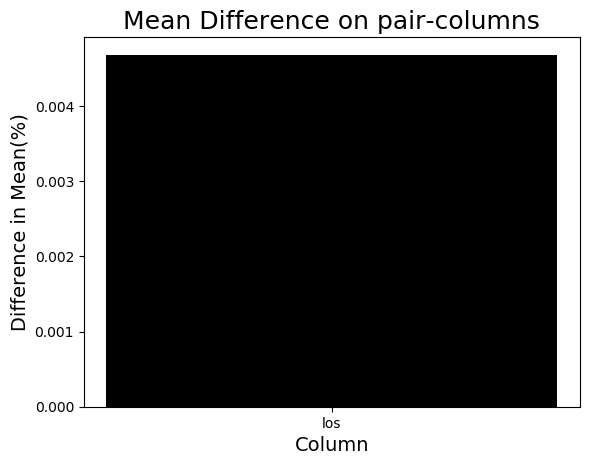

In [11]:
def variance(real_num_nor,syn_num_nor):
    var_real = pd.DataFrame(real_num_nor.var(), columns = ['real_var'])
    var_syn = pd.DataFrame(syn_num_nor.var(), columns = ['syn_var'])
    var_df = pd.concat([var_real, var_syn], axis=1, sort=False)
    var_df['diff'] = abs(var_df['real_var'] - var_df['syn_var'])
    return var_df

var_df = variance(real_num_nor,syn_num_nor)
# Plot the result
plot_result(var_df)

## 2) Categorical data

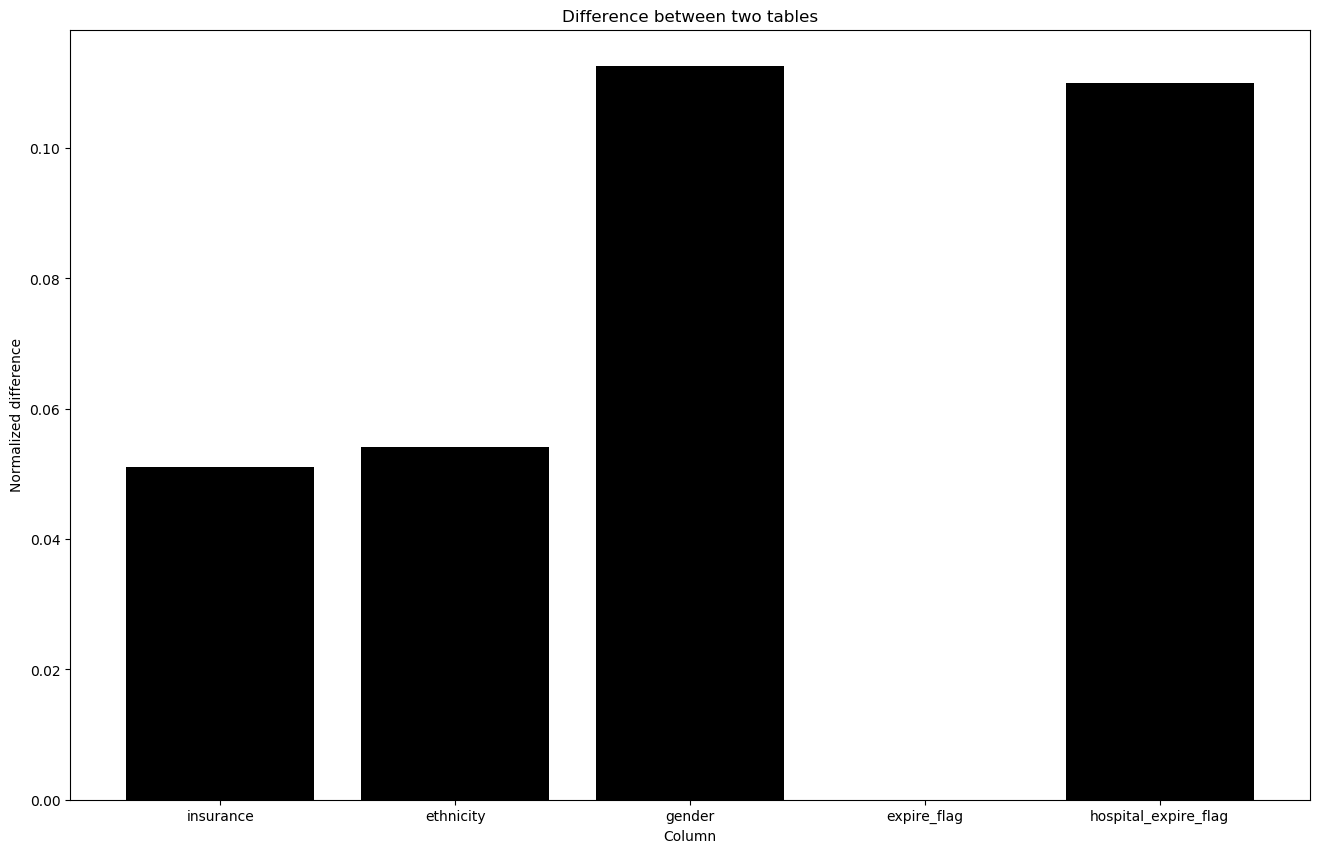

In [12]:
def plot_cat_freq_diff(real_cat, syn_cat):
    result = []
    for col in real_cat.columns:
        freq_real = pd.DataFrame(real_cat[col].value_counts()/len(real_cat.index))
        freq_syn = pd.DataFrame(syn_cat[col].value_counts()/len(syn_cat.index))
        freq_df = pd.concat([freq_real, freq_syn], axis=1, sort=False)
        freq_df['diff'] = abs(freq_df.iloc[:,0] - freq_df.iloc[:,1])
        result.append(freq_df['diff'].mean())

    plt.figure(figsize=(16,10))
    y_co = result
    x_co = real_cat.columns
    plt.bar(x_co,y_co, color = 'black')
    plt.title('Difference between two tables')
    plt.xlabel('Column')
    plt.ylabel('Normalized difference')
    return plt.show() 
    
    
plot_cat_freq_diff(real_cat, syn_cat)

## Probability Distribution (KL-divergence)

The lower the KL divergence, the closer the two distributions are to one another.

In [13]:
# For numeric values
def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

C:\Users\olivi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


[0, 40, 0, 90]

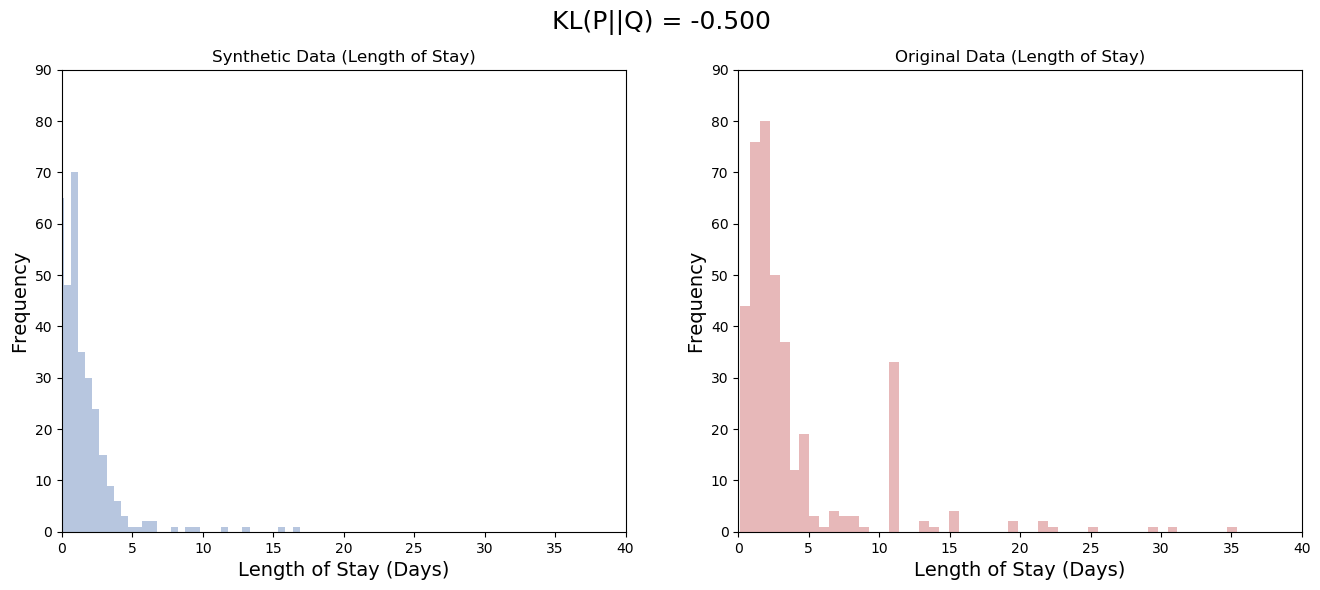

In [22]:
#### Testing the function
plt.figure(figsize = [16, 6])
plt.suptitle('KL(P||Q) = %1.3f' % kl_divergence(syn_num.ix[0,:], real_num.ix[0,:]),fontsize = 18)
plt.subplot(121)
sns.distplot(syn_num, color = 'b', kde = False)
plt.title('Synthetic Data (Length of Stay)')
plt.xlabel("Length of Stay (Days)",fontsize = 14)
plt.ylabel("Frequency",fontsize = 14)
plt.axis([0, 40, 0, 90])
plt.subplot(122)
sns.distplot(real_num, color = 'r', kde = False)
plt.title('Original Data (Length of Stay)')
plt.xlabel("Length of Stay (Days)",fontsize = 14)
plt.ylabel("Frequency",fontsize = 14)
plt.axis([0, 40, 0, 90])

## 3) Time Series Data

In [15]:
real_ts.head()

""
0
1
2
3
4


In [16]:
syn_ts.head()

""
0
1
2
3
4


## 4) ID Data

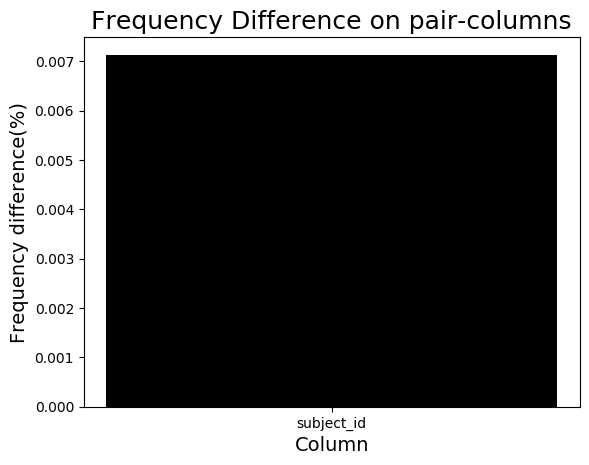

In [17]:
# Evaluate by frequency
def plot_id_freq_diff(real_cat, syn_cat):
    result = []
    for col in real_cat.columns:
        freq_real = pd.DataFrame(real_cat[col].value_counts()/len(real_cat.index))
        freq_syn = pd.DataFrame(syn_cat[col].value_counts()/len(syn_cat.index))
        freq_df = pd.concat([freq_real, freq_syn], axis=1, sort=False)
        freq_df['diff'] = abs(freq_df.iloc[:,0] - freq_df.iloc[:,1])
        result.append(freq_df['diff'].mean())

    
    y_co = result
    x_co = real_cat.columns
    plt.bar(x_co,y_co, width = 0.5, color = 'black')
    plt.title('Frequency Difference on pair-columns',fontsize=18)
    plt.xlabel('Column',fontsize=14)
    plt.ylabel('Frequency difference(%)',fontsize=14)
    return plt.show() 
    

plot_id_freq_diff(real_id, syn_id)